In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import GPyOpt
import torch
from torch import Tensor
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.optim
from torch.optim import SGD
import torch.nn.functional as F

import sys
sys.path.append('../code')

import toy_data as toy
from vae import VAE, loss_function, cVAE, fit
import vae as v
import notebook_utils as nu

from functools import partial

from IPython.core.debugger import set_trace
from IPython.display import display, Markdown, Latex

# Some parameters:
N = 360000  # number of observations
batch_size = 128
d = 64  # image edge length
D = d**2
img_shape = (d, d)
latent_dim = 4
print(f"{N} points with {D} dimensions.")

plot_sample_grid = partial(nu.plot_sample_grid, img_shape=img_shape)

# setting up torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Pytorch: Train with {device}')
device = torch.device(device)

# parameters:
eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32
labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
                               drop_last=True, batch_size=batch_size)}
dataloader = {'train': data_loader,
              'val': val_loader}

# dataloader with size comparable of PCA's datasize limit
subsets = {k: Subset(h, np.random.choice(range(len(v)), size=5000)) for k, v in zip(['train', 'val'], [h, h_val])}
reduced_dataloader = {k: DataLoader(subsets[k], batch_size=batch_size, drop_last=True) for k in subsets}

# # generate, encode, and decode new image for validation
# idx = np.random.randint(0, len(h_val))
# test_img = h_val[idx]['image']
# test_angles = h_val[idx]['angles']
# # h.plot_image(np.random.randint(0, len(labels)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
360000 points with 4096 dimensions.
Pytorch: Train with cuda
Bone lengths: [11.20685904 10.66501626  8.98942791]


## Bayesian optimization of latent dimension and beta for bernoulli/gaussian cVAE

Experimental result: it does not really matter as long as beta < 1.

In [13]:
# d = [np.load('bayesoptXY.npz'), np.load('bayesoptXY_2.npz')]
# X = np.concatenate((d[0]['X'], d[1]['X']), axis=0)
# Y = np.concatenate((d[0]['Y'], d[1]['Y']), axis=0)
d = np.load('bayesoptXY_3.npz')
X, Y = d['X'], d['Y']

In [ ]:
def f(inp):
    beta = inp[0, 0]
    latent_dim = inp[0, 1]
    display(Markdown(f'### beta: {beta:.2f}, latent: {int(latent_dim)}'))
    try:
        cvae = cVAE(input_dim=D, latent_dim=int(latent_dim),
                    pose_dim=3, likelihood='bernoulli',
                    hidden=1500).to(device)
        val_loss = fit(cvae, dataloader, epochs=1, device=device, 
                       weight_fn=f'beta{beta:.2f}dim{latent_dim}.pt',
                       # weight_fn=None,
                  conditional=True, plotter=plotter, beta=beta)
    except RuntimeError:
        print('Runtime Error')
        return [[np.nan]]
    # del cvae
    # torch.cuda.empty_cache()
    return val_loss

plotter = nu.VisdomLinePlotter(env_name='main')
bounds = [
          {'name': 'var_1', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (2, 40)}
]
opt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, num_cores=4, model_type='GP',
                                          initial_design_numdata=2, initial_design_type='latin',
                                          verbosity_model=True, exact_feval=False,
                                          X=X, Y=Y)

In [ ]:
for i in range(5):
    opt.plot_acquisition()
    opt.run_optimization(max_iter=1)
    np.savez('bayesoptXY_3.npz', X=opt.X, Y=opt.Y)

# Gaussian VAE

In [44]:
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//40)),
                               drop_last=True, batch_size=batch_size),
              'pretrain': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=N//40)),
                               drop_last=True, batch_size=batch_size)}
reduced_dataloader['pretrain'] = DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
                           drop_last=True, batch_size=batch_size)

In [18]:
save_weights = False
weight_fn = 'gaussianVAEweights.pt' if save_weights else None

def f(x):
    beta = x[0, 0]
    latent_dim = int(x[0, 1])
    hidden = int(x[0, 2])
    pre_dim = int(x[0, 3])
    display(Markdown(f'### beta: {beta:.2f}, latent: {int(latent_dim)}, hidden: {int(hidden)}\
    pre_dim: {int(pre_dim)}'))
    model = VAE(input_dim=D, latent_dim=latent_dim, pre_dim=500,
                hidden=200, likelihood='normal').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_func = v.joint_loss
    val_loss = fit(model, dataloader, device=device, optimizer=optimizer,
                     epochs=1, loss_func=loss_func, weight_fn=weight_fn,
                     plotter=plotter, stop_crit=0, beta=beta)
    return val_loss

plotter = nu.VisdomLinePlotter(env_name='main')
bounds = [
          {'name': 'var_1', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (2, 40)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (100, 300)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (150, 600)}
]
opt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, num_cores=4, model_type='GP',
                                          initial_design_numdata=16, initial_design_type='latin',
                                          verbosity_model=True, exact_feval=False)
                                          # X=X, Y=Y)

### beta: 1.19, latent: 7, hidden: 106    pre_dim: 220


pretrain loss: 2.01E-03



train loss: 1.23E-06
val loss: 3.14E-03


### beta: 0.19, latent: 3, hidden: 231    pre_dim: 276


pretrain loss: 2.02E-03



train loss: 1.06E-06
val loss: 3.86E-03


### beta: 0.44, latent: 38, hidden: 168    pre_dim: 501


pretrain loss: 2.03E-03



train loss: 9.32E-07
val loss: 3.99E-03


### beta: 1.81, latent: 24, hidden: 131    pre_dim: 248


pretrain loss: 2.01E-03



train loss: 1.54E-06
val loss: 3.35E-03


### beta: 1.06, latent: 15, hidden: 281    pre_dim: 192


pretrain loss: 2.03E-03



train loss: 1.13E-06
val loss: 3.15E-03


### beta: 0.69, latent: 19, hidden: 243    pre_dim: 304


pretrain loss: 2.02E-03



train loss: 9.34E-07
val loss: 3.31E-03


### beta: 0.06, latent: 36, hidden: 181    pre_dim: 557


pretrain loss: 2.02E-03



train loss: 2.87E-07
val loss: 7.67E-03


### beta: 0.81, latent: 12, hidden: 293    pre_dim: 529


pretrain loss: 2.04E-03



train loss: 9.97E-07
val loss: 3.15E-03


### beta: 0.56, latent: 17, hidden: 156    pre_dim: 360


pretrain loss: 2.03E-03



train loss: 8.39E-07
val loss: 3.43E-03


### beta: 1.31, latent: 29, hidden: 206    pre_dim: 445


pretrain loss: 2.04E-03



train loss: 1.32E-06
val loss: 3.29E-03


### beta: 1.56, latent: 26, hidden: 143    pre_dim: 164


pretrain loss: 2.04E-03



train loss: 1.38E-06
val loss: 3.11E-03


### beta: 1.94, latent: 10, hidden: 118    pre_dim: 473


pretrain loss: 2.02E-03



train loss: 1.53E-06
val loss: 3.32E-03


### beta: 0.94, latent: 5, hidden: 193    pre_dim: 332


pretrain loss: 2.01E-03



train loss: 1.12E-06
val loss: 3.20E-03


### beta: 1.69, latent: 22, hidden: 268    pre_dim: 417


pretrain loss: 2.02E-03



train loss: 1.46E-06
val loss: 3.19E-03


### beta: 1.44, latent: 31, hidden: 256    pre_dim: 389


pretrain loss: 2.02E-03



train loss: 1.36E-06
val loss: 3.27E-03


### beta: 0.31, latent: 34, hidden: 218    pre_dim: 585


pretrain loss: 2.02E-03



train loss: 6.44E-07
val loss: 4.01E-03


### beta: 0.54, latent: 18, hidden: 155    pre_dim: 361


pretrain loss: 2.02E-03



train loss: 8.44E-07
val loss: 3.49E-03


### beta: 1.61, latent: 23, hidden: 131    pre_dim: 197


pretrain loss: 2.05E-03



train loss: 1.39E-06
val loss: 3.11E-03


### beta: 2.00, latent: 2, hidden: 153    pre_dim: 325


pretrain loss: 2.03E-03



train loss: 1.84E-06
val loss: 4.69E-03


### beta: 0.00, latent: 4, hidden: 190    pre_dim: 364


pretrain loss: 2.04E-03



train loss: 7.84E-07
val loss: 4.64E-03


### beta: 1.15, latent: 13, hidden: 125    pre_dim: 175


pretrain loss: 2.03E-03



train loss: 1.21E-06
val loss: 3.12E-03


### beta: 1.42, latent: 14, hidden: 211    pre_dim: 319


pretrain loss: 2.03E-03



train loss: 1.31E-06
val loss: 3.18E-03


### beta: 1.17, latent: 5, hidden: 152    pre_dim: 184


pretrain loss: 2.02E-03



train loss: 1.26E-06
val loss: 3.34E-03


### beta: 0.00, latent: 33, hidden: 100    pre_dim: 196


pretrain loss: 2.03E-03



train loss: 1.21E-07
val loss: 2.21E-02


### beta: 2.00, latent: 19, hidden: 140    pre_dim: 185


pretrain loss: 2.01E-03



train loss: 1.56E-06
val loss: 3.36E-03


### beta: 2.00, latent: 11, hidden: 138    pre_dim: 206


pretrain loss: 2.04E-03



train loss: 1.63E-06
val loss: 3.37E-03


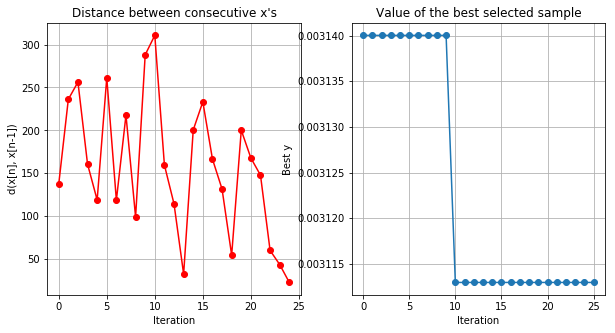

### beta: 1.90, latent: 2, hidden: 115    pre_dim: 232


pretrain loss: 2.02E-03



train loss: 1.87E-06
val loss: 4.73E-03


### beta: 0.79, latent: 5, hidden: 136    pre_dim: 164


pretrain loss: 2.03E-03



train loss: 1.06E-06
val loss: 3.18E-03


### beta: 1.47, latent: 28, hidden: 246    pre_dim: 411


pretrain loss: 2.02E-03



train loss: 1.34E-06
val loss: 3.13E-03


### beta: 1.93, latent: 30, hidden: 146    pre_dim: 204


pretrain loss: 2.02E-03



train loss: 1.62E-06
val loss: 3.57E-03


### beta: 1.82, latent: 9, hidden: 255    pre_dim: 401


pretrain loss: 2.02E-03



train loss: 1.49E-06
val loss: 3.25E-03


### beta: 1.17, latent: 9, hidden: 247    pre_dim: 428


pretrain loss: 2.03E-03



train loss: 1.14E-06
val loss: 3.05E-03


### beta: 2.00, latent: 29, hidden: 233    pre_dim: 437


pretrain loss: 2.03E-03



train loss: 1.62E-06
val loss: 3.51E-03


### beta: 0.42, latent: 10, hidden: 225    pre_dim: 415


pretrain loss: 2.04E-03



train loss: 7.02E-07
val loss: 3.23E-03


### beta: 0.00, latent: 2, hidden: 221    pre_dim: 442


pretrain loss: 2.02E-03



train loss: 1.43E-06
val loss: 5.16E-03


### beta: 1.73, latent: 36, hidden: 214    pre_dim: 416


pretrain loss: 2.03E-03



train loss: 1.51E-06
val loss: 3.53E-03


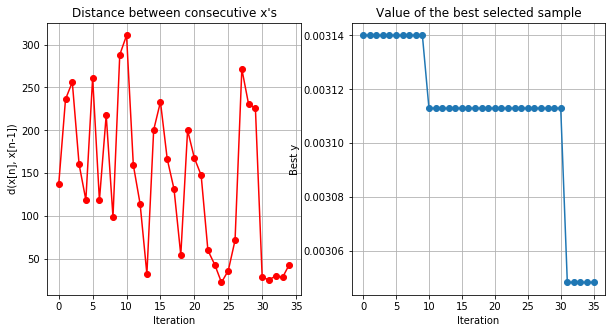

### beta: 0.00, latent: 2, hidden: 233    pre_dim: 326


pretrain loss: 2.02E-03



train loss: 1.40E-06
val loss: 5.16E-03


### beta: 1.68, latent: 27, hidden: 193    pre_dim: 321


pretrain loss: 2.02E-03



train loss: 1.39E-06
val loss: 3.21E-03


### beta: 1.76, latent: 32, hidden: 216    pre_dim: 301


pretrain loss: 2.02E-03



train loss: 1.54E-06
val loss: 3.56E-03


### beta: 0.98, latent: 7, hidden: 194    pre_dim: 305


pretrain loss: 2.03E-03



train loss: 1.06E-06
val loss: 3.04E-03


### beta: 0.00, latent: 20, hidden: 230    pre_dim: 391


pretrain loss: 2.02E-03



train loss: 1.50E-07
val loss: 1.35E-02


### beta: 2.00, latent: 29, hidden: 266    pre_dim: 399


pretrain loss: 2.04E-03



train loss: 1.60E-06
val loss: 3.52E-03


### beta: 2.00, latent: 28, hidden: 252    pre_dim: 425


pretrain loss: 2.04E-03



train loss: 1.60E-06
val loss: 3.45E-03


### beta: 2.00, latent: 2, hidden: 262    pre_dim: 415


pretrain loss: 2.02E-03



train loss: 1.86E-06
val loss: 4.74E-03


### beta: 2.00, latent: 21, hidden: 219    pre_dim: 426


pretrain loss: 2.01E-03



train loss: 1.56E-06
val loss: 3.37E-03


### beta: 2.00, latent: 40, hidden: 269    pre_dim: 375


pretrain loss: 2.03E-03



train loss: 1.65E-06
val loss: 3.84E-03


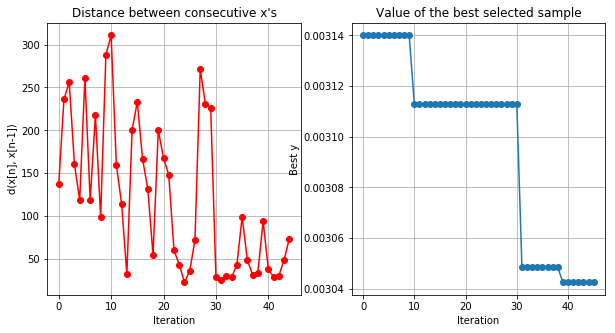

### beta: 2.00, latent: 40, hidden: 194    pre_dim: 429


pretrain loss: 2.01E-03



train loss: 1.64E-06
val loss: 3.84E-03


### beta: 1.48, latent: 27, hidden: 188    pre_dim: 294


pretrain loss: 2.01E-03



train loss: 1.34E-06
val loss: 3.18E-03


### beta: 2.00, latent: 2, hidden: 130    pre_dim: 186


pretrain loss: 2.05E-03



train loss: 1.80E-06
val loss: 4.58E-03


### beta: 0.00, latent: 11, hidden: 164    pre_dim: 163


pretrain loss: 2.02E-03



train loss: 2.35E-07
val loss: 8.17E-03


### beta: 0.00, latent: 13, hidden: 207    pre_dim: 290


pretrain loss: 2.03E-03



train loss: 1.87E-07
val loss: 8.96E-03


### beta: 2.00, latent: 12, hidden: 185    pre_dim: 314


pretrain loss: 2.03E-03



train loss: 1.55E-06
val loss: 3.31E-03


### beta: 2.00, latent: 19, hidden: 129    pre_dim: 160


pretrain loss: 2.03E-03



train loss: 1.53E-06
val loss: 3.31E-03


### beta: 2.00, latent: 38, hidden: 215    pre_dim: 319


pretrain loss: 2.02E-03



train loss: 1.68E-06
val loss: 3.78E-03


### beta: 2.00, latent: 40, hidden: 182    pre_dim: 303


pretrain loss: 2.04E-03



train loss: 1.67E-06
val loss: 3.79E-03


### beta: 2.00, latent: 40, hidden: 238    pre_dim: 300


pretrain loss: 2.02E-03



train loss: 1.66E-06
val loss: 3.72E-03


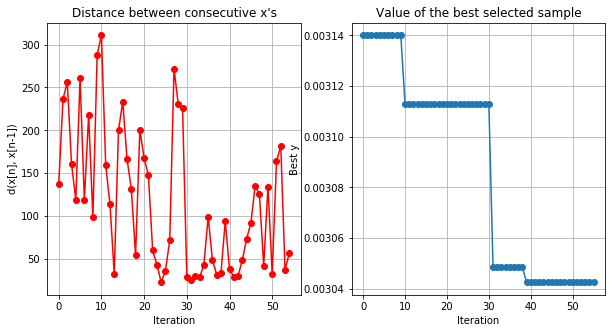

### beta: 1.22, latent: 11, hidden: 254    pre_dim: 282


pretrain loss: 2.02E-03



train loss: 1.21E-06
val loss: 3.10E-03


### beta: 2.00, latent: 14, hidden: 236    pre_dim: 423


pretrain loss: 2.02E-03



train loss: 1.62E-06
val loss: 3.35E-03


### beta: 0.12, latent: 2, hidden: 250    pre_dim: 262


pretrain loss: 2.02E-03



train loss: 1.40E-06
val loss: 4.72E-03


### beta: 2.00, latent: 23, hidden: 265    pre_dim: 297


pretrain loss: 2.03E-03



train loss: 1.57E-06
val loss: 3.37E-03


### beta: 2.00, latent: 21, hidden: 169    pre_dim: 289


pretrain loss: 2.02E-03



train loss: 1.60E-06
val loss: 3.38E-03


### beta: 1.86, latent: 31, hidden: 150    pre_dim: 263


pretrain loss: 2.03E-03



train loss: 1.55E-06
val loss: 3.51E-03


### beta: 1.79, latent: 26, hidden: 285    pre_dim: 513


pretrain loss: 2.03E-03



train loss: 1.48E-06
val loss: 3.30E-03


### beta: 1.51, latent: 30, hidden: 282    pre_dim: 537


pretrain loss: 2.03E-03



train loss: 1.39E-06
val loss: 3.35E-03


### beta: 0.45, latent: 11, hidden: 271    pre_dim: 526


pretrain loss: 2.04E-03



train loss: 7.26E-07
val loss: 3.27E-03


### beta: 2.00, latent: 6, hidden: 281    pre_dim: 549


pretrain loss: 2.02E-03



train loss: 1.55E-06
val loss: 3.41E-03


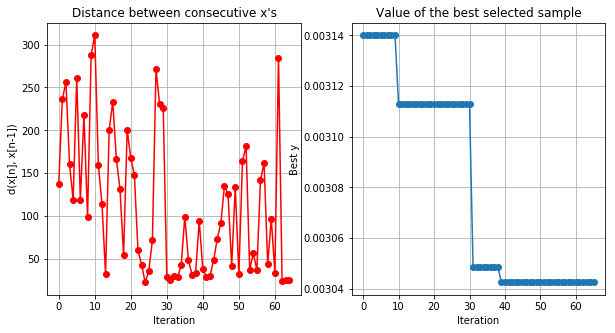

### beta: 0.92, latent: 29, hidden: 298    pre_dim: 192


pretrain loss: 2.02E-03



train loss: 1.07E-06
val loss: 3.21E-03


### beta: 1.49, latent: 16, hidden: 294    pre_dim: 173


pretrain loss: 2.01E-03



train loss: 1.36E-06
val loss: 3.12E-03


### beta: 0.52, latent: 33, hidden: 279    pre_dim: 178


pretrain loss: 2.02E-03



train loss: 9.64E-07
val loss: 3.65E-03


### beta: 2.00, latent: 2, hidden: 197    pre_dim: 317


pretrain loss: 2.02E-03



train loss: 1.89E-06
val loss: 4.73E-03


### beta: 0.00, latent: 20, hidden: 203    pre_dim: 336


pretrain loss: 2.03E-03



train loss: 1.55E-07
val loss: 1.36E-02


### beta: 2.00, latent: 25, hidden: 191    pre_dim: 310


pretrain loss: 2.03E-03



train loss: 1.60E-06
val loss: 3.37E-03


### beta: 0.00, latent: 18, hidden: 135    pre_dim: 171


pretrain loss: 2.04E-03



train loss: 1.48E-07
val loss: 1.20E-02


### beta: 1.43, latent: 11, hidden: 190    pre_dim: 309


pretrain loss: 2.02E-03



train loss: 1.37E-06
val loss: 3.17E-03


### beta: 1.54, latent: 15, hidden: 244    pre_dim: 425


pretrain loss: 2.02E-03



train loss: 1.39E-06
val loss: 3.14E-03


### beta: 2.00, latent: 19, hidden: 138    pre_dim: 194


pretrain loss: 2.03E-03



train loss: 1.55E-06
val loss: 3.39E-03


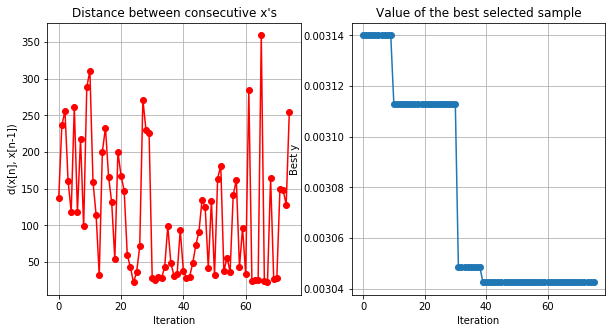

### beta: 1.57, latent: 22, hidden: 250    pre_dim: 417


pretrain loss: 2.02E-03



train loss: 1.38E-06
val loss: 3.19E-03


### beta: 2.00, latent: 11, hidden: 119    pre_dim: 176


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.39E-03


### beta: 2.00, latent: 18, hidden: 126    pre_dim: 154


pretrain loss: 2.03E-03



train loss: 1.60E-06
val loss: 3.33E-03


### beta: 2.00, latent: 31, hidden: 145    pre_dim: 158


pretrain loss: 2.04E-03



train loss: 1.61E-06
val loss: 3.54E-03


### beta: 1.13, latent: 20, hidden: 290    pre_dim: 184


pretrain loss: 2.02E-03



train loss: 1.16E-06
val loss: 3.04E-03


### beta: 2.00, latent: 2, hidden: 132    pre_dim: 159


pretrain loss: 2.04E-03



train loss: 1.88E-06
val loss: 4.74E-03


### beta: 1.73, latent: 26, hidden: 258    pre_dim: 410


pretrain loss: 2.02E-03



train loss: 1.44E-06
val loss: 3.24E-03


### beta: 1.12, latent: 19, hidden: 283    pre_dim: 527


pretrain loss: 2.03E-03



train loss: 1.13E-06
val loss: 3.02E-03


### beta: 1.08, latent: 12, hidden: 282    pre_dim: 536


pretrain loss: 2.02E-03



train loss: 1.15E-06
val loss: 3.11E-03


### beta: 0.89, latent: 8, hidden: 283    pre_dim: 525


pretrain loss: 2.03E-03



train loss: 1.00E-06
val loss: 3.00E-03


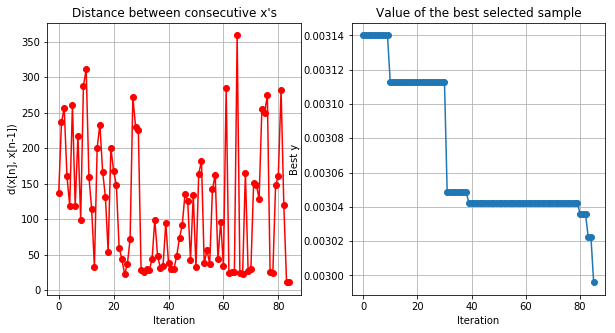

### beta: 1.25, latent: 17, hidden: 253    pre_dim: 293


pretrain loss: 2.01E-03



train loss: 1.22E-06
val loss: 3.06E-03


### beta: 2.00, latent: 16, hidden: 149    pre_dim: 190


pretrain loss: 2.03E-03



train loss: 1.57E-06
val loss: 3.30E-03


### beta: 1.27, latent: 14, hidden: 283    pre_dim: 179


pretrain loss: 2.03E-03



train loss: 1.24E-06
val loss: 3.14E-03


### beta: 1.68, latent: 20, hidden: 180    pre_dim: 300


pretrain loss: 2.04E-03



train loss: 1.44E-06
val loss: 3.16E-03


### beta: 1.33, latent: 2, hidden: 185    pre_dim: 332


pretrain loss: 2.02E-03



train loss: 1.62E-06
val loss: 4.50E-03


### beta: 2.00, latent: 27, hidden: 182    pre_dim: 317


pretrain loss: 2.02E-03



train loss: 1.58E-06
val loss: 3.47E-03


### beta: 0.00, latent: 15, hidden: 279    pre_dim: 516


pretrain loss: 2.03E-03



train loss: 1.82E-07
val loss: 1.03E-02


### beta: 1.95, latent: 5, hidden: 279    pre_dim: 531


pretrain loss: 2.02E-03



train loss: 1.50E-06
val loss: 3.38E-03


### beta: 2.00, latent: 21, hidden: 288    pre_dim: 533


pretrain loss: 2.01E-03



train loss: 1.59E-06
val loss: 3.38E-03


### beta: 2.00, latent: 33, hidden: 289    pre_dim: 515


pretrain loss: 2.02E-03



train loss: 1.57E-06
val loss: 3.53E-03


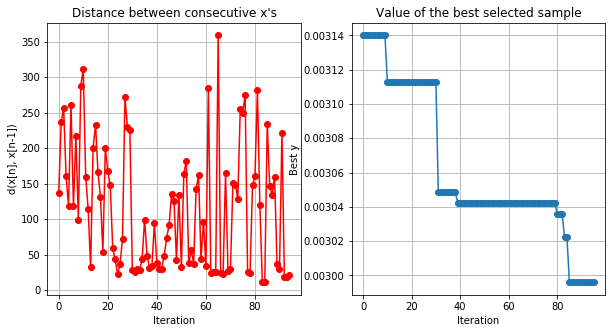

### beta: 1.51, latent: 18, hidden: 274    pre_dim: 534


pretrain loss: 2.03E-03



train loss: 1.35E-06
val loss: 3.14E-03


### beta: 2.00, latent: 26, hidden: 131    pre_dim: 154


pretrain loss: 2.00E-03



train loss: 1.60E-06
val loss: 3.39E-03


### beta: 0.85, latent: 6, hidden: 183    pre_dim: 302


pretrain loss: 2.03E-03



train loss: 1.05E-06
val loss: 3.14E-03


### beta: 0.42, latent: 21, hidden: 259    pre_dim: 285


pretrain loss: 2.02E-03



train loss: 7.54E-07
val loss: 3.74E-03


### beta: 0.00, latent: 5, hidden: 288    pre_dim: 529


pretrain loss: 2.03E-03



train loss: 6.49E-07
val loss: 4.93E-03


### beta: 1.52, latent: 10, hidden: 291    pre_dim: 184


pretrain loss: 2.02E-03



train loss: 1.36E-06
val loss: 3.12E-03


### beta: 2.00, latent: 20, hidden: 217    pre_dim: 313


pretrain loss: 2.02E-03



train loss: 1.59E-06
val loss: 3.41E-03


### beta: 0.00, latent: 9, hidden: 267    pre_dim: 535


pretrain loss: 2.03E-03



train loss: 3.11E-07
val loss: 6.76E-03


### beta: 0.74, latent: 11, hidden: 244    pre_dim: 289


pretrain loss: 2.02E-03



train loss: 9.41E-07
val loss: 3.11E-03


### beta: 2.00, latent: 13, hidden: 280    pre_dim: 530


pretrain loss: 2.01E-03



train loss: 1.60E-06
val loss: 3.37E-03


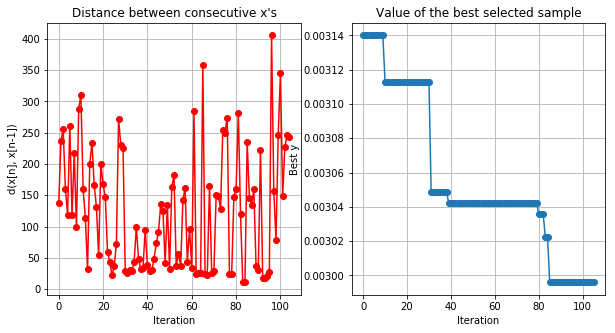

### beta: 1.16, latent: 18, hidden: 293    pre_dim: 195


pretrain loss: 2.01E-03



train loss: 1.16E-06
val loss: 3.07E-03


### beta: 2.00, latent: 6, hidden: 254    pre_dim: 293


pretrain loss: 2.04E-03



train loss: 1.52E-06
val loss: 3.36E-03


### beta: 0.00, latent: 26, hidden: 277    pre_dim: 531


pretrain loss: 2.03E-03



train loss: 1.33E-07
val loss: 1.74E-02


### beta: 2.00, latent: 14, hidden: 276    pre_dim: 535


pretrain loss: 2.02E-03



train loss: 1.59E-06
val loss: 3.38E-03


### beta: 1.25, latent: 15, hidden: 287    pre_dim: 185


pretrain loss: 2.02E-03



train loss: 1.27E-06
val loss: 3.11E-03


### beta: 1.19, latent: 12, hidden: 251    pre_dim: 289


pretrain loss: 2.04E-03



train loss: 1.21E-06
val loss: 3.11E-03


### beta: 1.70, latent: 28, hidden: 252    pre_dim: 415


pretrain loss: 2.04E-03



train loss: 1.45E-06
val loss: 3.29E-03


### beta: 1.62, latent: 16, hidden: 287    pre_dim: 528


pretrain loss: 2.01E-03



train loss: 1.43E-06
val loss: 3.23E-03


### beta: 2.00, latent: 32, hidden: 285    pre_dim: 540


pretrain loss: 2.02E-03



train loss: 1.64E-06
val loss: 3.68E-03


### beta: 1.30, latent: 16, hidden: 293    pre_dim: 188


pretrain loss: 2.03E-03



train loss: 1.26E-06
val loss: 3.13E-03


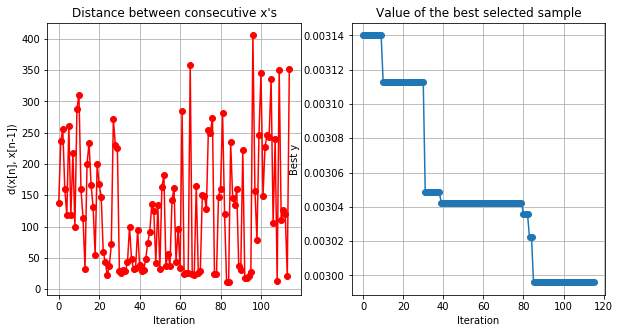

### beta: 1.38, latent: 15, hidden: 291    pre_dim: 179


pretrain loss: 2.03E-03



train loss: 1.34E-06
val loss: 3.19E-03


### beta: 1.00, latent: 20, hidden: 287    pre_dim: 191


pretrain loss: 2.03E-03



train loss: 1.12E-06
val loss: 3.13E-03


### beta: 1.44, latent: 14, hidden: 185    pre_dim: 304


pretrain loss: 2.03E-03



train loss: 1.34E-06
val loss: 3.19E-03


### beta: 1.07, latent: 13, hidden: 247    pre_dim: 296


pretrain loss: 2.03E-03



train loss: 1.15E-06
val loss: 3.11E-03


### beta: 0.33, latent: 19, hidden: 245    pre_dim: 291


pretrain loss: 2.05E-03



train loss: 6.36E-07
val loss: 3.86E-03


### beta: 1.56, latent: 23, hidden: 187    pre_dim: 301


pretrain loss: 2.02E-03



train loss: 1.38E-06
val loss: 3.11E-03


### beta: 1.34, latent: 19, hidden: 185    pre_dim: 295


pretrain loss: 2.03E-03



train loss: 1.27E-06
val loss: 3.11E-03


### beta: 0.00, latent: 5, hidden: 187    pre_dim: 308


pretrain loss: 2.02E-03



train loss: 6.51E-07
val loss: 5.01E-03


### beta: 2.00, latent: 19, hidden: 186    pre_dim: 311


pretrain loss: 2.04E-03



train loss: 1.58E-06
val loss: 3.32E-03


### beta: 2.00, latent: 13, hidden: 192    pre_dim: 302


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.34E-03


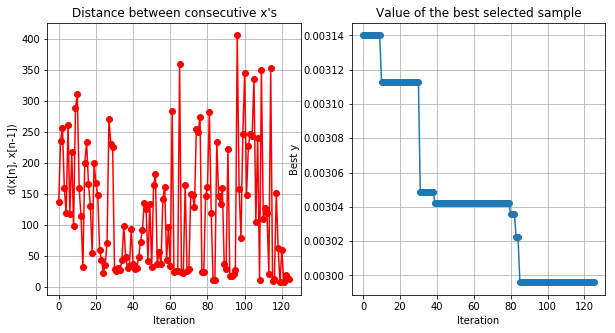

### beta: 1.75, latent: 16, hidden: 291    pre_dim: 538


pretrain loss: 2.02E-03



train loss: 1.48E-06
val loss: 3.23E-03


### beta: 2.00, latent: 24, hidden: 293    pre_dim: 190


pretrain loss: 2.03E-03



train loss: 1.62E-06
val loss: 3.43E-03


### beta: 0.40, latent: 21, hidden: 281    pre_dim: 184


pretrain loss: 2.01E-03



train loss: 6.99E-07
val loss: 3.74E-03


### beta: 0.87, latent: 19, hidden: 296    pre_dim: 531


pretrain loss: 2.03E-03



train loss: 1.04E-06
val loss: 3.14E-03


### beta: 1.73, latent: 25, hidden: 243    pre_dim: 420


pretrain loss: 2.02E-03



train loss: 1.47E-06
val loss: 3.22E-03


### beta: 2.00, latent: 11, hidden: 180    pre_dim: 296


pretrain loss: 2.04E-03



train loss: 1.57E-06
val loss: 3.34E-03


### beta: 0.00, latent: 11, hidden: 288    pre_dim: 193


pretrain loss: 2.03E-03



train loss: 2.66E-07
val loss: 7.81E-03


### beta: 2.00, latent: 19, hidden: 277    pre_dim: 193


pretrain loss: 2.03E-03



train loss: 1.53E-06
val loss: 3.32E-03


### beta: 0.59, latent: 21, hidden: 299    pre_dim: 196


pretrain loss: 2.04E-03



train loss: 8.61E-07
val loss: 3.38E-03


### beta: 1.98, latent: 25, hidden: 179    pre_dim: 293


pretrain loss: 2.03E-03



train loss: 1.56E-06
val loss: 3.39E-03


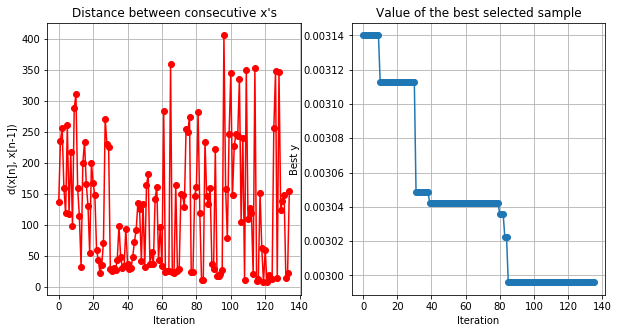

### beta: 1.70, latent: 16, hidden: 255    pre_dim: 301


pretrain loss: 2.03E-03



train loss: 1.41E-06
val loss: 3.14E-03


### beta: 2.00, latent: 13, hidden: 276    pre_dim: 186


pretrain loss: 2.04E-03



train loss: 1.58E-06
val loss: 3.29E-03


### beta: 2.00, latent: 13, hidden: 298    pre_dim: 181


pretrain loss: 2.01E-03



train loss: 1.62E-06
val loss: 3.40E-03


### beta: 1.94, latent: 14, hidden: 197    pre_dim: 310


pretrain loss: 2.02E-03



train loss: 1.61E-06
val loss: 3.38E-03


### beta: 1.85, latent: 18, hidden: 253    pre_dim: 406


pretrain loss: 2.02E-03



train loss: 1.52E-06
val loss: 3.29E-03


### beta: 1.47, latent: 20, hidden: 260    pre_dim: 419


pretrain loss: 2.02E-03



train loss: 1.33E-06
val loss: 3.10E-03


### beta: 1.03, latent: 16, hidden: 254    pre_dim: 426


pretrain loss: 2.02E-03



train loss: 1.12E-06
val loss: 3.09E-03


### beta: 2.00, latent: 7, hidden: 290    pre_dim: 177


pretrain loss: 2.04E-03



train loss: 1.58E-06
val loss: 3.28E-03


### beta: 0.00, latent: 11, hidden: 249    pre_dim: 419


pretrain loss: 2.01E-03



train loss: 2.18E-07
val loss: 8.03E-03


### beta: 2.00, latent: 16, hidden: 247    pre_dim: 431


pretrain loss: 2.02E-03



train loss: 1.58E-06
val loss: 3.30E-03


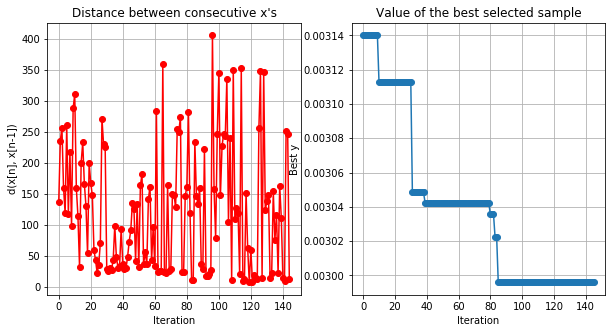

### beta: 2.00, latent: 11, hidden: 241    pre_dim: 430


pretrain loss: 2.03E-03



train loss: 1.57E-06
val loss: 3.32E-03


### beta: 2.00, latent: 5, hidden: 248    pre_dim: 284


pretrain loss: 2.03E-03



train loss: 1.57E-06
val loss: 3.56E-03


### beta: 2.00, latent: 21, hidden: 240    pre_dim: 427


pretrain loss: 2.02E-03



train loss: 1.57E-06
val loss: 3.38E-03


### beta: 2.00, latent: 21, hidden: 259    pre_dim: 428


pretrain loss: 2.03E-03



train loss: 1.55E-06
val loss: 3.33E-03


### beta: 2.00, latent: 19, hidden: 259    pre_dim: 399


pretrain loss: 2.05E-03



train loss: 1.60E-06
val loss: 3.33E-03


### beta: 0.00, latent: 14, hidden: 261    pre_dim: 294


pretrain loss: 2.01E-03



train loss: 1.82E-07
val loss: 9.60E-03


### beta: 2.00, latent: 20, hidden: 251    pre_dim: 300


pretrain loss: 2.03E-03



train loss: 1.61E-06
val loss: 3.38E-03


### beta: 2.00, latent: 29, hidden: 265    pre_dim: 299


pretrain loss: 2.01E-03



train loss: 1.60E-06
val loss: 3.44E-03


### beta: 2.00, latent: 19, hidden: 264    pre_dim: 409


pretrain loss: 2.02E-03



train loss: 1.57E-06
val loss: 3.31E-03


### beta: 2.00, latent: 13, hidden: 251    pre_dim: 305


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.26E-03


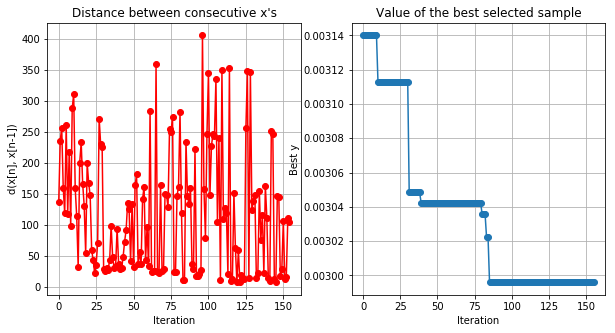

### beta: 2.00, latent: 18, hidden: 251    pre_dim: 282


pretrain loss: 2.03E-03



train loss: 1.60E-06
val loss: 3.31E-03


### beta: 2.00, latent: 24, hidden: 291    pre_dim: 199


pretrain loss: 2.04E-03



train loss: 1.57E-06
val loss: 3.34E-03


### beta: 2.00, latent: 16, hidden: 284    pre_dim: 544


pretrain loss: 2.03E-03



train loss: 1.60E-06
val loss: 3.26E-03


### beta: 1.63, latent: 22, hidden: 136    pre_dim: 204


pretrain loss: 2.02E-03



train loss: 1.42E-06
val loss: 3.22E-03


### beta: 2.00, latent: 22, hidden: 292    pre_dim: 523


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.30E-03


### beta: 2.00, latent: 10, hidden: 254    pre_dim: 433


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.34E-03


### beta: 2.00, latent: 29, hidden: 289    pre_dim: 507


pretrain loss: 2.03E-03



train loss: 1.57E-06
val loss: 3.41E-03


### beta: 2.00, latent: 28, hidden: 254    pre_dim: 401


pretrain loss: 2.02E-03



train loss: 1.60E-06
val loss: 3.56E-03


### beta: 2.00, latent: 15, hidden: 130    pre_dim: 201


pretrain loss: 2.03E-03



train loss: 1.59E-06
val loss: 3.32E-03


### beta: 0.40, latent: 18, hidden: 227    pre_dim: 420


pretrain loss: 2.02E-03



train loss: 7.19E-07
val loss: 3.69E-03


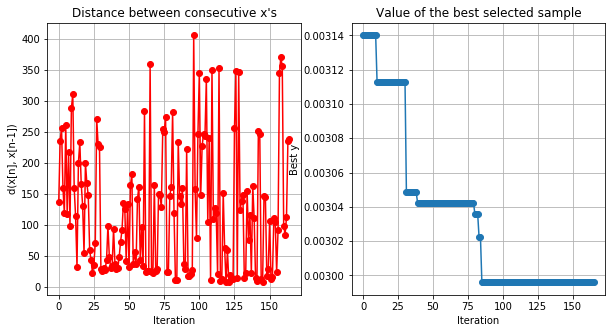

### beta: 2.00, latent: 5, hidden: 248    pre_dim: 294


pretrain loss: 2.03E-03



train loss: 1.53E-06
val loss: 3.43E-03


### beta: 2.00, latent: 24, hidden: 122    pre_dim: 158


pretrain loss: 2.03E-03



train loss: 1.56E-06
val loss: 3.34E-03


### beta: 2.00, latent: 28, hidden: 255    pre_dim: 290


pretrain loss: 2.03E-03



train loss: 1.55E-06
val loss: 3.41E-03


### beta: 2.00, latent: 25, hidden: 145    pre_dim: 190


pretrain loss: 2.02E-03



train loss: 1.57E-06
val loss: 3.38E-03


### beta: 2.00, latent: 30, hidden: 136    pre_dim: 197


pretrain loss: 2.03E-03



train loss: 1.58E-06
val loss: 3.50E-03


### beta: 0.00, latent: 28, hidden: 263    pre_dim: 419


pretrain loss: 2.01E-03



train loss: 1.30E-07
val loss: 1.87E-02


### beta: 2.00, latent: 17, hidden: 268    pre_dim: 416


pretrain loss: 2.03E-03



train loss: 1.52E-06
val loss: 3.25E-03


### beta: 2.00, latent: 17, hidden: 259    pre_dim: 417


pretrain loss: 2.03E-03



train loss: 1.59E-06
val loss: 3.39E-03


### beta: 2.00, latent: 19, hidden: 191    pre_dim: 317


pretrain loss: 2.04E-03



train loss: 1.61E-06
val loss: 3.33E-03


### beta: 2.00, latent: 25, hidden: 253    pre_dim: 409


pretrain loss: 2.05E-03



train loss: 1.54E-06
val loss: 3.37E-03


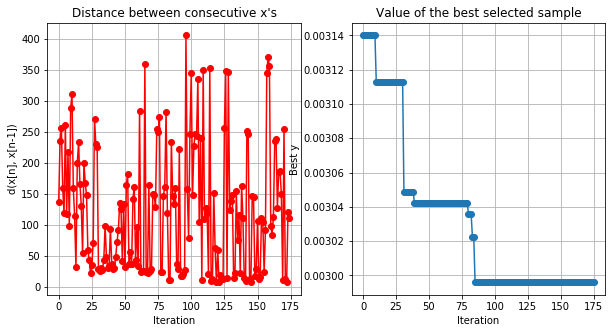

In [19]:
for i in range(16):
    opt.run_optimization(max_iter=10)
    opt.plot_convergence()
    np.savez('bayesopt_vae.npz', X=opt.X, Y=opt.Y)

In [20]:
# opt.run_optimization(max_iter=100)
np.savez('bayesopt_vae_val_with_kl.npz', X=opt.X, Y=opt.Y)

In [36]:
opt.x_opt

array([  0.89475525,   8.82072447, 283.42353364, 525.83457358])

ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.
ERROR:visdom:Connection is already closed.


In [30]:
best_idx = np.where(opt.X[:, 0] == opt.x_opt[0])[0][0]

In [31]:
opt.Y[best_idx]

array([0.00299589])

In [33]:
best_idx

85

In [37]:
x = opt.x_opt[None]
beta = x[0, 0]
latent_dim = int(x[0, 1])
hidden = int(x[0, 2])
pre_dim = int(x[0, 3])
display(Markdown(f'### beta: {beta:.2f}, latent: {int(latent_dim)}, hidden: {int(hidden)}\
pre_dim: {int(pre_dim)}'))
model = VAE(input_dim=D, latent_dim=latent_dim, pre_dim=500,
            hidden=200, likelihood='normal').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = v.joint_loss
val_loss = fit(model, dataloader, device=device, optimizer=optimizer,
                 epochs=3, loss_func=loss_func, weight_fn='gaussianVAEoptimal.pt',
                 plotter=plotter, stop_crit=0, beta=beta)

### beta: 0.89, latent: 8, hidden: 283pre_dim: 525


pretrain loss: 2.04E-03



train loss: 1.03E-06
val loss: 3.06E-03



train loss: 9.50E-07
val loss: 2.81E-03



train loss: 9.10E-07
val loss: 2.72E-03


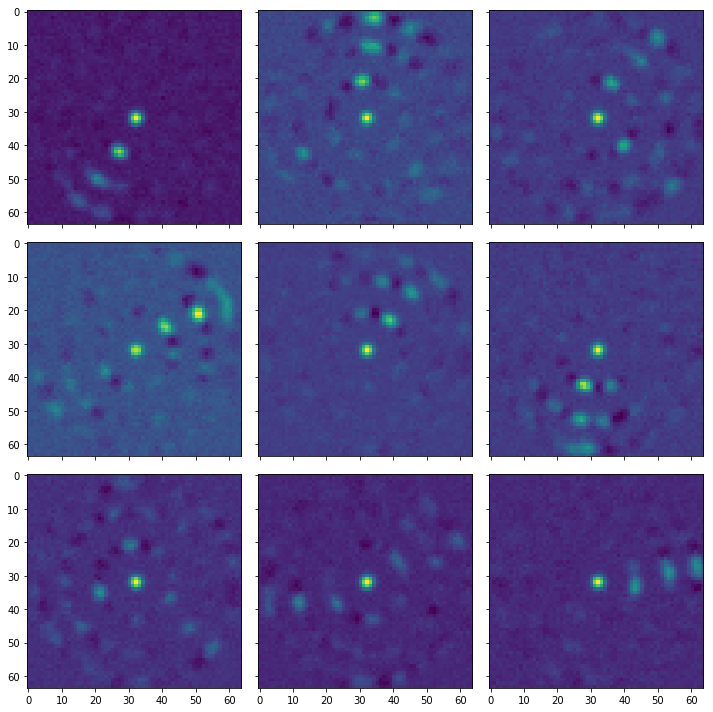

In [40]:
nu.plot_sample_grid(nu.draw_samples(model), (64, 64))

In [42]:
# parameters:
N = 360000
batch_size = 128
d = 64  # image edge length
D = d**2
img_shape = (d, d)
latent_dim = 4
print(f"{N} points with {D} dimensions.")

eps = np.random.rand(3)
bone_lengths = d//6 * (eps/2+1-1/3)
print("Bone lengths:", bone_lengths)
key_marker_width = 1.5 * d/32
labels = 1/2*np.pi*(np.random.rand(N, 3)-0.5)
labels[:, 0] = labels[:, 0] * 4

# generate training data
h = toy.HierarchyImages(angles=labels, bone_lengths=bone_lengths,
                        key_marker_width=key_marker_width,
                        img_shape=img_shape)

# data loader for easy batching
data_loader = DataLoader(h, batch_size=batch_size, shuffle=True, num_workers=4,
                         drop_last=True)

# generate validation data
labels_val = 1/2*np.pi*(np.random.rand(N//10, 3)-0.5)
labels_val[:, 0] = labels_val[:, 0] * 4

h_val = toy.HierarchyImages(angles=labels_val, bone_lengths=bone_lengths,
                            key_marker_width=key_marker_width,
                            img_shape=img_shape)

val_loader = DataLoader(h_val, batch_size=batch_size, shuffle=False, num_workers=4,
                        drop_last=True)

# dataloader dictionary with reduced validation set size
dataloader = {'train': data_loader,
              'val': DataLoader(torch.utils.data.Subset(h_val, np.random.choice(range(len(h_val)), size=1024)),
                               drop_last=True, batch_size=batch_size)}
dataloader = {'train': data_loader,
              'val': val_loader}

360000 points with 4096 dimensions.
Bone lengths: [9.54257198 6.89280464 7.91528768]


In [45]:
x = opt.x_opt[None]
beta = x[0, 0]
latent_dim = int(x[0, 1])
hidden = int(x[0, 2])
pre_dim = int(x[0, 3])
display(Markdown(f'### beta: {beta:.2f}, latent: {int(latent_dim)}, hidden: {int(hidden)}\
pre_dim: {int(pre_dim)}'))
model = VAE(input_dim=D, latent_dim=latent_dim, pre_dim=500,
            hidden=200, likelihood='normal').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = v.joint_loss
val_loss = fit(model, dataloader, device=device, optimizer=optimizer,
                 epochs=3, loss_func=loss_func, weight_fn='gaussianVAEoptimal.pt',
                 plotter=plotter, stop_crit=0, beta=beta)

### beta: 0.89, latent: 8, hidden: 283pre_dim: 525


pretrain loss: 1.84E-03



train loss: 8.95E-07
val loss: 2.69E-03



train loss: 8.55E-07
val loss: 2.49E-03



train loss: 8.24E-07
val loss: 2.44E-03


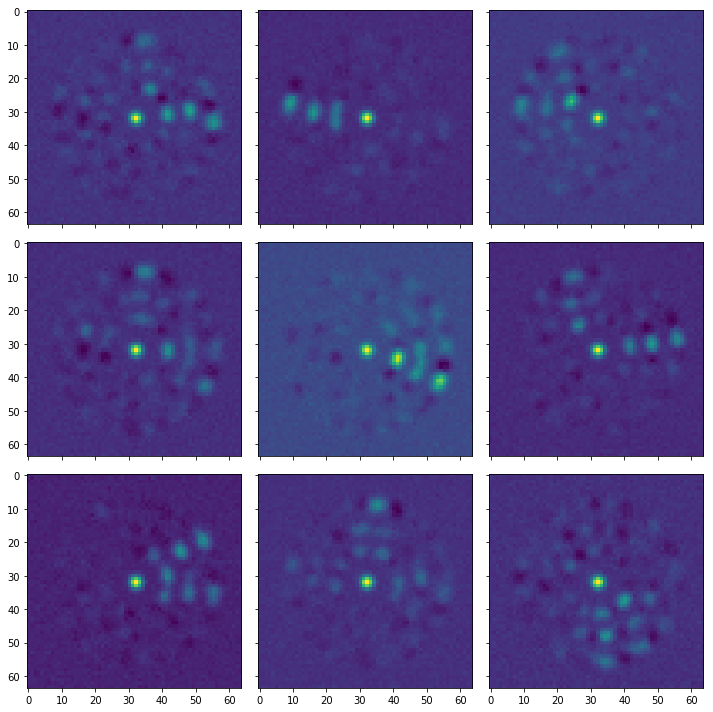

In [47]:
nu.plot_sample_grid(nu.draw_samples(model), (64, 64))